In [1]:
import torch
import torch.nn as nn 
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from skimage import io
import time

import warnings
warnings.filterwarnings("ignore")


 ### Veriyi dahil etme 

In [2]:
class Veri(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = io.imread(img_path)  # Değiştirilmiş satır: io.read_image'den io.imread'e
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))
        
        if self.transform:
            image = self.transform(image)
            
        return (image, y_label)


### Burdaki fotograf verileri sizde yok ama siz kendi verinizi etiketleyebilirisniz ve bunu csv dosysı şeklinde kaydedebilirsiniz 

###  Veriyi dahil etme 

In [3]:
dataset = Veri(
    csv_file="/Users/abdulbarisoylemez/Documents/Visual Code/Yapay Zeka ve Bilgisayarlı Görü Mühendisi/PytorchTemeleri/fotograf_etiketler.csv",
    root_dir="/Users/abdulbarisoylemez/Documents/Visual Code/Bitirme Projesi/kod/data/isaretData",
    transform=transforms.Compose([ 
        transforms.ToTensor(),
        transforms.Resize(size=(64, 64)),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
)


In [4]:
dataset

### Veri ön işeleme

In [5]:
total_length = len(dataset)
train_length = 1500  # Eğitim verisi sayısı
test_length = total_length - train_length  # Test verisi sayısı
# veriilerimiz random olarak değişkenlere atalım 
train_set, test_set = torch.utils.data.random_split(dataset, [train_length, test_length])

# DataLoader'ları oluşturmak
train_loader = DataLoader(dataset=train_set, batch_size=1, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=1, shuffle=True)


In [6]:
train_set

In [7]:
test_set

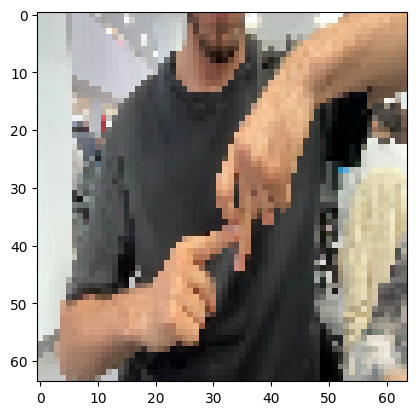

R    
torch.Size([1, 3, 64, 64])


In [8]:

import matplotlib.pyplot as plt
import numpy as np

batch_size = 1
classes = ["A", "B", "Bosluk", "C", "D", "DOT", "E", "F", "G", "H", "I", "K", "L", "M", "N", "O", "P", "R", "S", "SPACE", "T", "U", "V", "Y", "Z"]
#classes = [0,1, 2,3, 4, 5, 6, 7,8,9,10,11,12,13,14, 15,16,17, 18, 19,20,21, 22, 23,24]


def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

print(' '.join("%-5s" % classes[labels[j]] for j in range(batch_size)))
print(images.size())

## MODEL MİMARİSİNİ OLUŞTURMA 

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(5, 5))
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(5, 5))
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3))
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5, 5))

        self.max = nn.MaxPool2d(kernel_size=(2, 2))

        self.func = nn.ELU()

        self.fc1 = nn.Linear(in_features=64, out_features=124)
        self.fc2 = nn.Linear(in_features=124, out_features=124)
        self.fc3 = nn.Linear(in_features=124, out_features=100)
        self.fc4 = nn.Linear(in_features=100, out_features=25)

    def forward(self, x):
        x = self.conv1(x)
        x = self.func(x)
        x = self.max(x)

        x = self.conv2(x)
        x = self.func(x)
        x = self.max(x)

        x = self.conv3(x)
        x = self.func(x)
        x = self.max(x)

        x = self.conv4(x)
        x = self.func(x)

        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = self.func(x)

        x = self.fc2(x)
        x = self.func(x)

        x = self.fc3(x)
        x = self.func(x)

        x = self.fc4(x)

        return x


### Model eğitimi

In [10]:
start=time.time()
model = Net()

optimizer = torch.optim.Adamax(model.parameters(), lr=0.001)  

error = torch.nn.CrossEntropyLoss()

epoch = 10

for e in range(epoch):  

    for i, (images, labels) in enumerate(train_loader):

        optimizer.zero_grad()  

        tahmin = model(images)

        loss = error(tahmin, labels)

        loss.backward()

        optimizer.step()

        print("Epoch [{}/{}], loss: {:.6f}".format(e, epoch, loss.item())) 

end = time.time()
print("süre:", end - start)


Epoch [0/10], loss: 3.255440
Epoch [0/10], loss: 3.304838
Epoch [0/10], loss: 3.270906
Epoch [0/10], loss: 3.253470
Epoch [0/10], loss: 3.032046
Epoch [0/10], loss: 3.123585
Epoch [0/10], loss: 3.264965
Epoch [0/10], loss: 3.130510
Epoch [0/10], loss: 3.303275
Epoch [0/10], loss: 3.112461
Epoch [0/10], loss: 3.263849
Epoch [0/10], loss: 3.339496
Epoch [0/10], loss: 3.356601
Epoch [0/10], loss: 3.174869
Epoch [0/10], loss: 3.232523
Epoch [0/10], loss: 3.317438
Epoch [0/10], loss: 3.317559
Epoch [0/10], loss: 3.047169
Epoch [0/10], loss: 3.187993
Epoch [0/10], loss: 3.289160
Epoch [0/10], loss: 2.951655
Epoch [0/10], loss: 3.333677
Epoch [0/10], loss: 3.312077
Epoch [0/10], loss: 2.997674
Epoch [0/10], loss: 3.403877
Epoch [0/10], loss: 3.295396
Epoch [0/10], loss: 3.362744
Epoch [0/10], loss: 3.204548
Epoch [0/10], loss: 3.183645
Epoch [0/10], loss: 3.242247
Epoch [0/10], loss: 2.880704
Epoch [0/10], loss: 3.153226
Epoch [0/10], loss: 3.374048
Epoch [0/10], loss: 3.357374
Epoch [0/10], 

### Model testi

In [11]:
def dogruluk(loader,model):
     num_correct=0
     num_samples=0
     model.eval()

     with torch.no_grad():
          for x,y in loader:
               tahmin=model(x)
               _,pred=tahmin.max(1)
               num_correct+=(pred==y).sum()
               num_samples+=pred.size(0)
          print(
               f"got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}"
          )
          model.train()





In [12]:
print("train doğruluk :")
dogruluk(train_loader,model)
print("test doğruluk")
dogruluk(test_loader,model)

train doğruluk :
got 1494 / 1500 with accuracy 99.60
test doğruluk
got 499 / 500 with accuracy 99.80


" ### Model testi 2  """Adam algoritması"""

In [33]:
start=time.time()
model = Net()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  

error = torch.nn.CrossEntropyLoss()

epoch = 10
kayıp_list=[]
count=0
iterasyon=[]
basarı_list=[]
for e in range(epoch):  

    for i, (images, labels) in enumerate(train_loader): 

        tahmin = model(images)

        optimizer.zero_grad() 

        loss = error(tahmin, labels)

        loss.backward()

        optimizer.step()

        count+=1

        if count % 100 ==0:
            total=0
            correct=0
            correct_hata=0

            for images,labels in test_loader:
                
                out=model(images)
                pred=torch.max(out.data,1)[1]
                total+=len(labels)

                correct+=(pred==labels).sum()
                correct_hata+=(pred!=labels).sum()

            dogruluk=100*correct/float(total)
            hata=100*correct_hata/float(total)

            kayıp_list.append(loss.data)
            basarı_list.append(dogruluk)
            iterasyon.append(count)
        
        if count%100==0:
            print("iterasyon{}, loss: {},Accuracy: {} % Error: {}%".format(count, loss.data,dogruluk,hata)) 
       
end = time.time()
print("süre:", end - start)


iterasyon100, loss: 2.7965455055236816,Accuracy: 17.200000762939453 % Error: 82.80000305175781%
iterasyon200, loss: 0.5672062635421753,Accuracy: 32.400001525878906 % Error: 67.5999984741211%
iterasyon300, loss: 3.9173085689544678,Accuracy: 40.20000076293945 % Error: 59.79999923706055%
iterasyon400, loss: 0.34073200821876526,Accuracy: 55.599998474121094 % Error: 44.400001525878906%
iterasyon500, loss: 0.6114696860313416,Accuracy: 64.0 % Error: 36.0%
iterasyon600, loss: 0.05131824314594269,Accuracy: 58.599998474121094 % Error: 41.400001525878906%
iterasyon700, loss: 3.7051782608032227,Accuracy: 79.0 % Error: 21.0%
iterasyon800, loss: 2.114588737487793,Accuracy: 81.4000015258789 % Error: 18.600000381469727%
iterasyon900, loss: 0.02898084744811058,Accuracy: 72.0 % Error: 28.0%
iterasyon1000, loss: 0.01075059175491333,Accuracy: 84.4000015258789 % Error: 15.600000381469727%
iterasyon1100, loss: 0.19706809520721436,Accuracy: 63.20000076293945 % Error: 36.79999923706055%
iterasyon1200, loss: 0

## MODELİ KAYDETME 

In [34]:
torch.save(model,"ModelDil.pth")  # Modelin tamamını kaydetik

In [35]:
torch.save(model.state_dict(),"ModelDilAgirlik.pth") # Modelin ağırlıklarını kaydetik

#### Kaydetiğimiz modleimizi yükliyelim

In [36]:
Modelyükle=torch.load("ModelDil.pth")

##### modelin ağırlıklarına bakalım 

In [37]:
modelAgirl=Net()
modelAgirl.load_state_dict(torch.load("ModelDilAgirlik.pth"))
modelAgirl.eval()

Net(
  (conv1): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (max): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (func): ELU(alpha=1.0)
  (fc1): Linear(in_features=64, out_features=124, bias=True)
  (fc2): Linear(in_features=124, out_features=124, bias=True)
  (fc3): Linear(in_features=124, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=25, bias=True)
)

##### Ağırlıklı modelin dpğruluğu

In [39]:
def dogruluk(loader,model):
     num_correct=0
     num_samples=0
     model.eval()

     with torch.no_grad():
          for x,y in loader:
               tahmin=model(x)
               _,pred=tahmin.max(1)
               num_correct+=(pred==y).sum()
               num_samples+=pred.size(0)
          print(
               f"got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}"
          )
          model.train()


In [40]:
print("train doğruluk :")
dogruluk(train_loader,modelAgirl)
print("test doğruluk")
dogruluk(test_loader,modelAgirl)

train doğruluk :
got 1500 / 1500 with accuracy 100.00
test doğruluk
got 500 / 500 with accuracy 100.00


#### Genel modelin doğruluğuna bakalım

In [41]:
def dogruluk(loader,model):
     num_correct=0
     num_samples=0
     model.eval()

     with torch.no_grad():
          for x,y in loader:
               tahmin=model(x)
               _,pred=tahmin.max(1)
               num_correct+=(pred==y).sum()
               num_samples+=pred.size(0)
          print(
               f"got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}"
          )
          model.train()


In [42]:
print("train doğruluk :")
dogruluk(train_loader,Modelyükle)
print("test doğruluk")
dogruluk(test_loader,Modelyükle)

train doğruluk :
got 1500 / 1500 with accuracy 100.00
test doğruluk
got 500 / 500 with accuracy 100.00


### SUMMARY

In [43]:
from torchsummary import summary
summary(model,input_size=(3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 60, 60]             608
               ELU-2            [-1, 8, 60, 60]               0
         MaxPool2d-3            [-1, 8, 30, 30]               0
            Conv2d-4           [-1, 16, 26, 26]           3,216
               ELU-5           [-1, 16, 26, 26]               0
         MaxPool2d-6           [-1, 16, 13, 13]               0
            Conv2d-7           [-1, 32, 11, 11]           4,640
               ELU-8           [-1, 32, 11, 11]               0
         MaxPool2d-9             [-1, 32, 5, 5]               0
           Conv2d-10             [-1, 64, 1, 1]          51,264
              ELU-11             [-1, 64, 1, 1]               0
           Linear-12                  [-1, 124]           8,060
              ELU-13                  [-1, 124]               0
           Linear-14                  [

### LOSS görseleştirem 

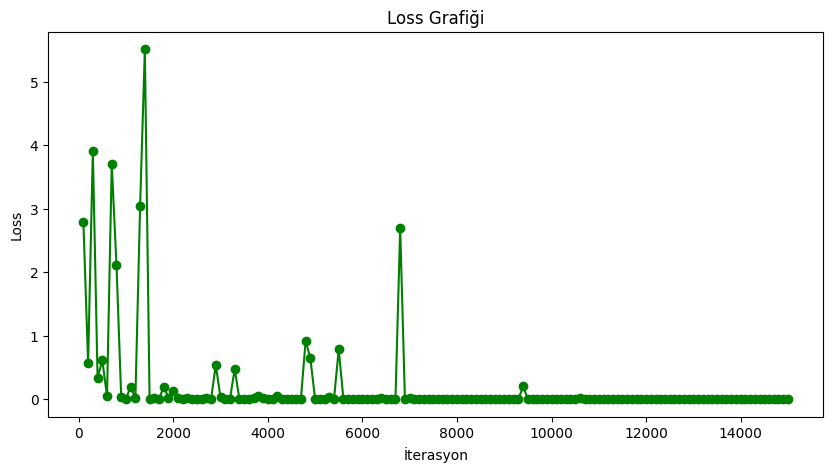

In [44]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10,5))
plt.title("Loss Grafiği")
plt.plot(iterasyon,kayıp_list,"-o",color="g")

plt.xlabel("İterasyon")
plt.ylabel("Loss")

plt.show()

### Accuracy Grafiği

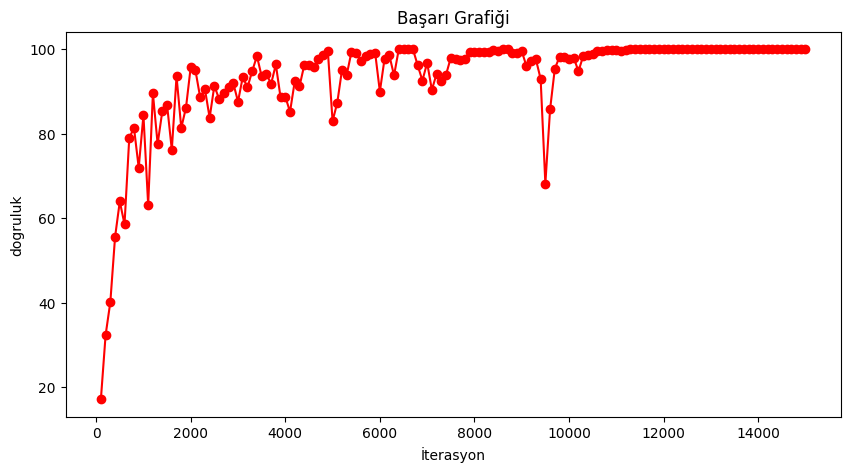

In [45]:
plt.figure(figsize=(10,5))
plt.title("Başarı Grafiği")
plt.plot(iterasyon,basarı_list,"-o",color="r")

plt.xlabel("İterasyon")
plt.ylabel("dogruluk")

plt.show()

#### Test verisinde tahmin yapalım

In [46]:
cals_name = ["A", "B", "Bosluk", "C", "D", "DOT", "E", "F", "G", "H", "I", "K", "L", "M", "N", "O", "P", "R", "S", "SPACE", "T", "U", "V", "Y", "Z"]


In [49]:
def gorsellestirme (model,image_sayısı=10):
     was_tranining=model.training
     model.eval()
     resimsayısı=0

     with torch.no_grad():
          for i,(images,labels) in enumerate(test_loader):
               output=model(images)
               _,tahmin=torch.max(output,1)
               
               for j in range( images.size()[0]):
                     plt.figure(figsize=(40,30))
                     resimsayısı+=1
                     ax=plt.subplot(image_sayısı//2,2,image_sayısı)
                     ax.axis("off")
                     ax.set_title("Tahmin : {}".format( cals_name[tahmin[j]]))
                     imshow(images.cpu().data[j])

                     if resimsayısı==image_sayısı:
                          model.train(was_tranining)
                          return

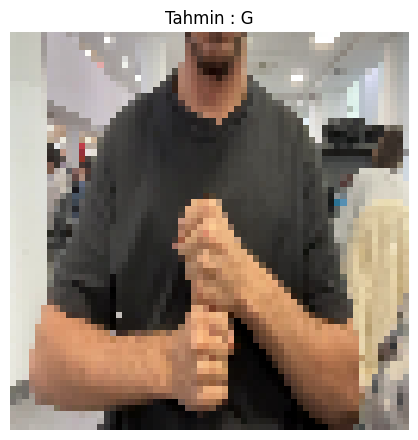

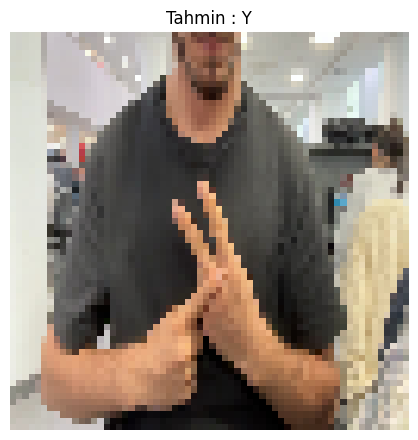

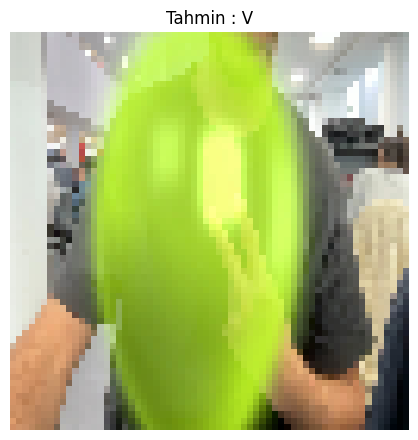

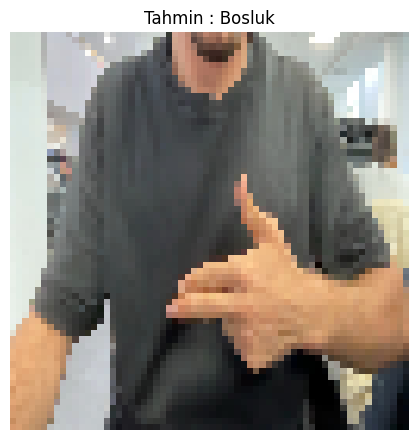

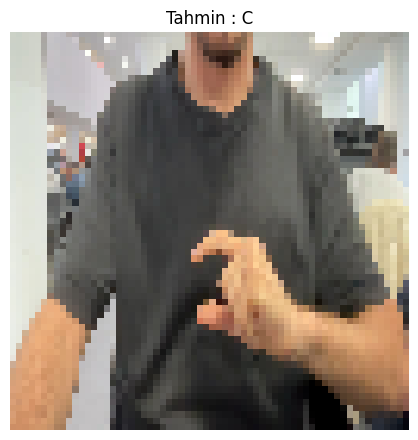

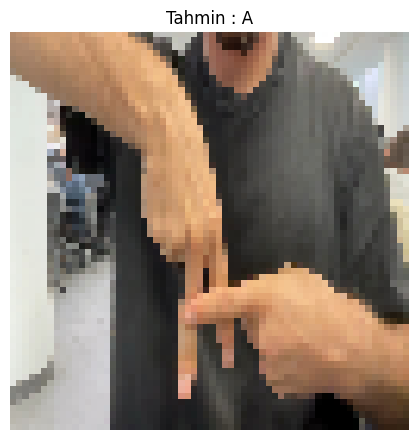

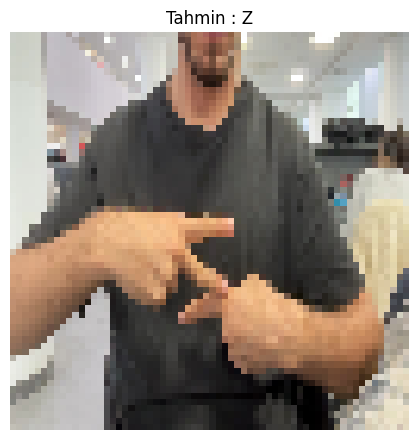

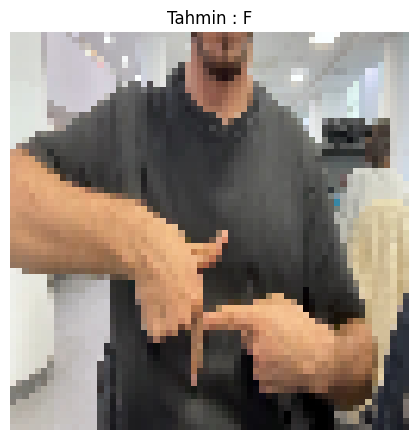

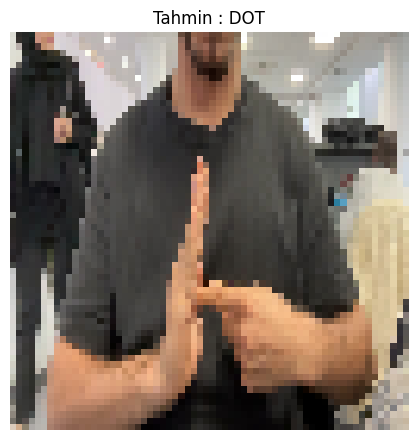

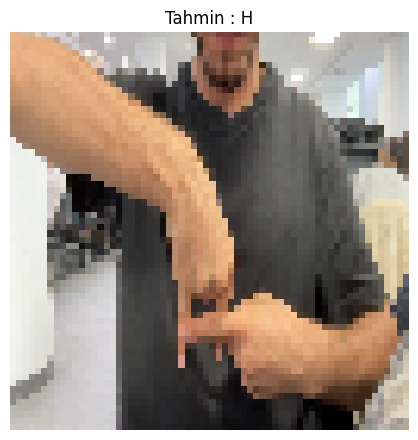

In [50]:
gorsellestirme(model)